<a href="https://colab.research.google.com/github/WenyiYao/cryptocurrency/blob/main/GRU_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from tensorflow import keras
from keras import layers
import keras_nlp
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import pandas as pd
import numpy as np

ModuleNotFoundError: ignored

In [ ]:
df = pd.read_json('USDC-ETH.json')
df.head()

In [ ]:
df = df.drop(columns=["id"])
df = df.set_index(['date'])
df.head()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'])])
fig.show()

In [ ]:
dataset = df.values
dataset

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
def create_sequence(dataset, sequence_length=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sequence_length-1):
        a = dataset[i:(i+sequence_length)]
        dataX.append(a)
        dataY.append(dataset[i+sequence_length,[0,1,7]]) #predict high, low, and close
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
sequence_length = 6
trainX, trainY = create_sequence(train, sequence_length)
testX, testY = create_sequence(test, sequence_length)

In [ ]:
print(trainX.shape)
print(trainY.shape)

In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [ ]:
batch_size = 1
epochs=10

model_gru = Sequential()
model_gru.add(GRU(6, batch_input_shape=(batch_size, sequence_length, 8), stateful=True, return_sequences=False))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

#history = model1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2, shuffle=False)

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Lists to store training loss at the end of each iteration
train_loss_history = []
test_loss_history = []

iterations = 10
epochs = 10

# Training loop
for iteration in range(iterations):
    print(f"Iteration {iteration + 1}/{iterations}")

    # Train the model with early stopping
    history = model_gru.fit(trainX, trainY, epochs=epochs, batch_size=batch_size,
                         verbose=2, shuffle=False)

    train_loss_history.extend(history.history['loss'])

    # Evaluate the model on the test set and store the test loss
    test_loss = model_gru.evaluate(testX, testY, batch_size=batch_size)
    test_loss_history.append(test_loss)

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (1, 6)                    288       
                                                                 
 dense (Dense)               (1, 3)                    21        
                                                                 
Total params: 309 (1.21 KB)
Trainable params: 309 (1.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


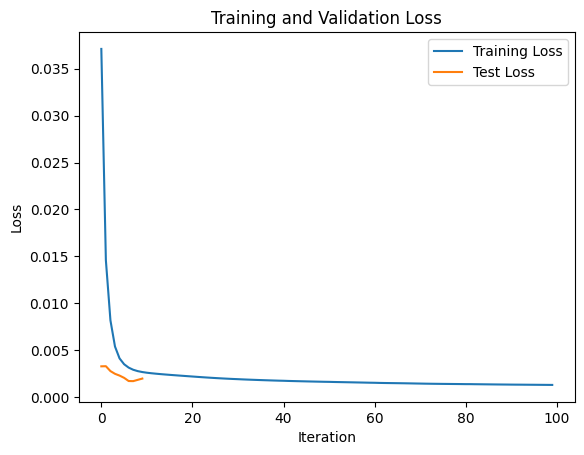

In [ ]:
# Plot training and validation loss
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(true, predicted):
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

# high value metrics
testPredict = model_gru.predict(testX, batch_size=batch_size)
calculate_metrics(testY[:, 0], testPredict[:, 0])

119/119 [==============================] - 1s 2ms/step


{'MSE': 0.0030268014446906033,
 'RMSE': 0.055016374332471266,
 'MAE': 0.04969469612068447,
 'R2': 0.7935888903837128}

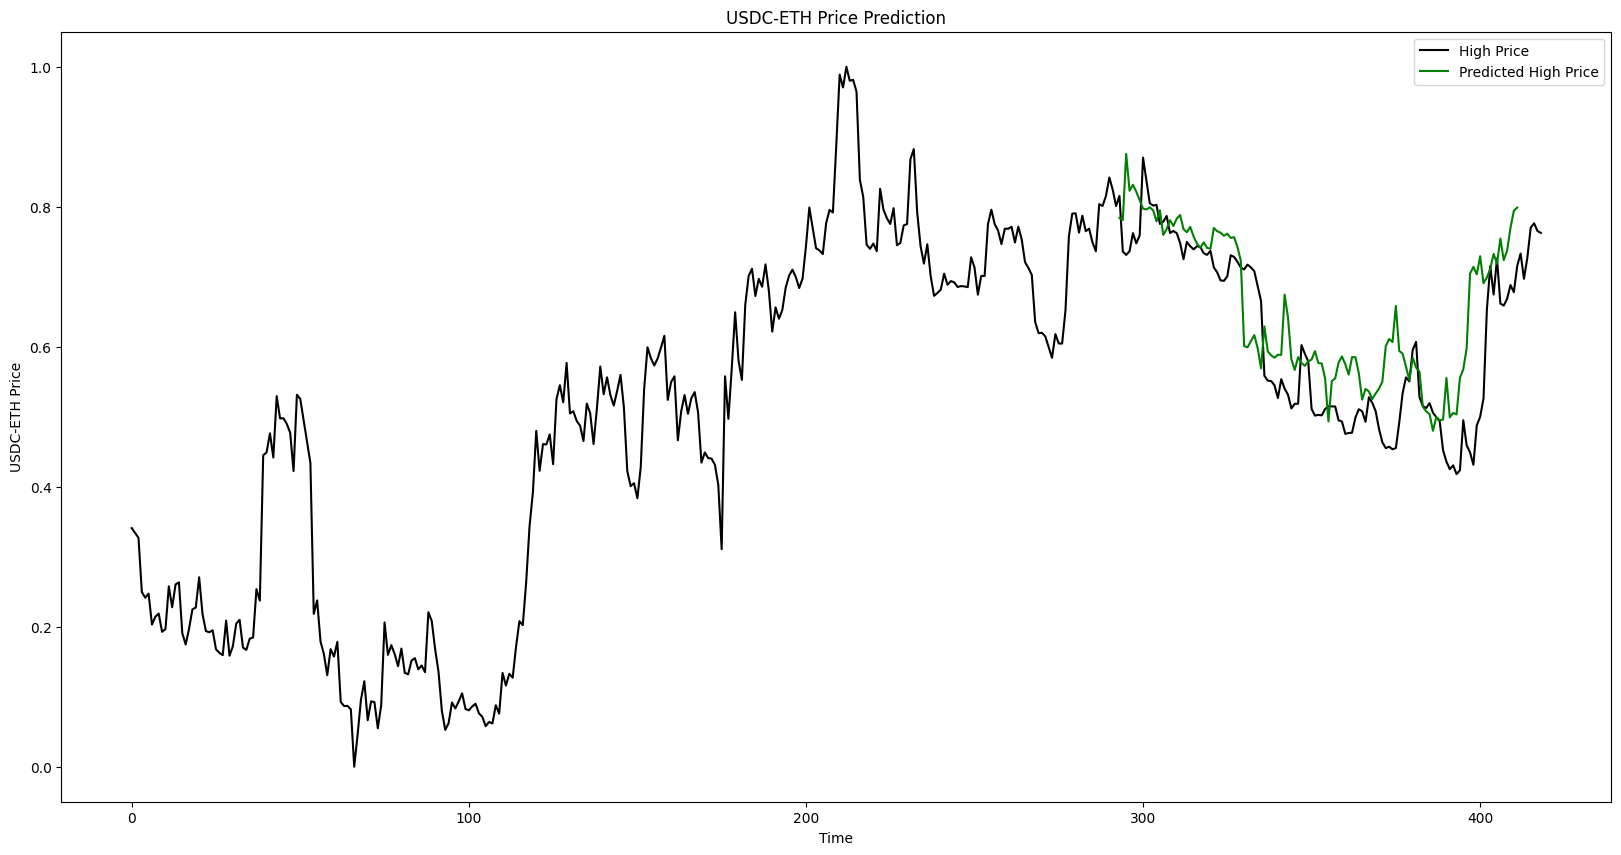

In [ ]:
date_index = train_size
plt.figure(figsize=(20, 10))
plt.plot(dataset[:,0], color = 'black', label = 'High Price')
plt.plot(range(date_index, date_index + len(testPredict)), testPredict[:, 0], color = 'green', label = 'Predicted High Price')
plt.title('USDC-ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('USDC-ETH Price')
plt.legend()
plt.show()


In [ ]:
trainPredict = model1.predict(trainX, batch_size=batch_size)
trainScore = math.sqrt(mean_squared_error(trainY[:, 0], trainPredict[:, 0]))
print('Train Score of high value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainY[:, 1], trainPredict[:, 1]))
print('Train Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainY[:, 2], trainPredict[:, 2]))
print('Train Score of close value: %.10f RMSE' % (trainScore))

NameError: ignored

In [ ]:
testPredict = model1.predict(testX, batch_size=batch_size)
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:, 0]))
print('Test Score of high value: %.10f RMSE' % (testScore))
trainScore = math.sqrt(mean_squared_error(testY[:, 1], testPredict[:, 1]))
print('Test Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(testY[:, 2], testPredict[:, 2]))
print('Test Score of close value: %.10f RMSE' % (trainScore))

In [ ]:
print(trainPredict.shape)
print(trainY.shape)

In [ ]:
print(testPredict.shape)
print(testY.shape)

In [ ]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], 0], label=("Predicted High"))
plt.plot(testY[:, 0], label=("Actual High"))
plt.title('Original high vs predicted high', fontsize=15)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], 1], label=("Predicted Low"))
plt.plot(testY[:, 1],label=("Actual Low"))
plt.title('Original low vs predicted low', fontsize=15)
plt.legend()
plt.show()

In [ ]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], 2], label=("Predicted Close"))
plt.plot(testY[:, 2], label=("Actual Close"))
plt.title('Original close vs predicted close', fontsize=15)
plt.legend()
plt.show()